# _import modules & set constants:_

In [1]:
# enable in-line MatPlotLib
%matplotlib inline

In [2]:
# import:
from __future__ import division, print_function
from matplotlib import pyplot
import multiprocessing
import numpy
import os
import pandas
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [3]:
# set CONSTANTS

# using AWS EMR?
AWS_EMR_MODE = os.path.expanduser('~') == '/home/hadoop'

# data paths
DATA_FILE_NAME = 'CreditScoring.csv'
DATA_URL = \
    'https://raw.githubusercontent.com/ChicagoBoothML/DATA___Kaggle___GiveMeSomeCredit/master/%s' % DATA_FILE_NAME

# number of examples to display for a data set
NB_EXAMPLES_TO_SHOW = 9

# random_seed
RANDOM_SEED = 99

In [4]:
# install ChicagoBoothML_Helpy
CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND = \
    'pip install --upgrade git+git://GitHub.com/ChicagoBoothML/Helpy --no-dependencies'
if AWS_EMR_MODE:
    os.system('sudo %s' % CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)
else:
    os.system(CHICAGOBOOTHML_HELPY_INSTALLATION_COMMAND)

# import from package
from ChicagoBoothML_Helpy.EvaluationMetrics import bin_classif_eval
from ChicagoBoothML_Helpy.Print import printflush

# import Kaggle's _"Give Me Some Credit"_ data set

In [5]:
# read Credit Scoring data into data frame
y_var_name = 'SeriousDlqin2yrs'
X_var_names = [
  'RevolvingUtilizationOfUnsecuredLines',
  'age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfTimes90DaysLate',
  'NumberRealEstateLoansOrLines',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents']

cs = pandas.read_csv(
    DATA_URL,
    dtype={
        'SeriousDlqin2yrs': int,
        'RevolvingUtilizationOfUnsecuredLines': float,
        'age': float,
        'NumberOfTime30-59DaysPastDueNotWorse': float,
        'DebtRatio': float,
        'MonthlyIncome': float,
        'NumberOfOpenCreditLinesAndLoans': float,
        'NumberOfTimes90DaysLate': float,
        'NumberRealEstateLoansOrLines': float,
        'NumberOfTime60-89DaysPastDueNotWorse': float,
        'NumberOfDependents': float},
    index_col=0,
    na_values='NA')

cs.loc[:, 'SeriousDlqin2yrs'] = pandas.Categorical(cs.SeriousDlqin2yrs)

nb_samples = len(cs)

cs

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120,13,0,6,0,2
2,0,0.957151,40,0,0.121876,2600,4,0,0,0,1
3,0,0.658180,38,1,0.085113,3042,2,1,0,0,0
4,0,0.233810,30,0,0.036050,3300,5,0,0,0,0
5,0,0.907239,49,1,0.024926,63588,7,0,1,0,0
6,0,0.213179,74,0,0.375607,3500,3,0,1,0,1
7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0
8,0,0.754464,39,0,0.209940,3500,8,0,0,0,0
9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
10,0,0.189169,57,0,0.606291,23684,9,0,4,0,2


Just to sanity-check, the classes of the variables are:

In [6]:
for col_name in cs:
    printflush('%s: %s' %(col_name, cs[col_name].dtype))

SeriousDlqin2yrs: category
RevolvingUtilizationOfUnsecuredLines: float64
age: float64
NumberOfTime30-59DaysPastDueNotWorse: float64
DebtRatio: float64
MonthlyIncome: float64
NumberOfOpenCreditLinesAndLoans: float64
NumberOfTimes90DaysLate: float64
NumberRealEstateLoansOrLines: float64
NumberOfTime60-89DaysPastDueNotWorse: float64
NumberOfDependents: float64


The incidence of loan delinquency in all samples is:

In [7]:
sum(cs.SeriousDlqin2yrs) / nb_samples

0.066839999999999997

Note that this creates a "**skewed classes**" problem: one of the classes of cases (here the "delinquent" class) is significantly rarer than the other.

_(**note**: in more extreme cases where one class is much, much rarer than the other to the order of 1000 or 10,000 times, our model fitting procedures would need to be tweaked; but this case is not so extreme)_

Let's split the data into a Training set and a Test set:

In [8]:
cs_train, cs_test = train_test_split(
    cs,
    train_size=.2,
    random_state=RANDOM_SEED)

Let's also split a bit of data from the Training set as a Validation set for the purpose of estimating OOS performance metrics:

In [9]:
cs_train, cs_valid = train_test_split(
    cs_train,
    train_size=2. / 3.,
    random_state=RANDOM_SEED)

Just to sanity-check that the data sets have been split representatively: the delinquency incidences in the Training, Validation and Test sets are:

In [10]:
for data_set in (cs_train, cs_valid, cs_test):
    printflush('%i obs: %f delinquent' %(len(data_set), sum(data_set.SeriousDlqin2yrs) / len(data_set)))

20000 obs: 0.064750 delinquent
10000 obs: 0.067800 delinquent
120000 obs: 0.067108 delinquent


The proportions of missing data points per column in the Training set are as follows:

In [11]:
cs_train.isnull().sum() / len(cs_train)

SeriousDlqin2yrs                        0.0000
RevolvingUtilizationOfUnsecuredLines    0.0000
age                                     0.0000
NumberOfTime30-59DaysPastDueNotWorse    0.0000
DebtRatio                               0.0000
MonthlyIncome                           0.1991
NumberOfOpenCreditLinesAndLoans         0.0000
NumberOfTimes90DaysLate                 0.0000
NumberRealEstateLoansOrLines            0.0000
NumberOfTime60-89DaysPastDueNotWorse    0.0000
NumberOfDependents                      0.0254
dtype: float64

Let's not throw away valuable data just because of missing values; let's impute missing with the means of the respective columns in the _**Training**_ set:

In [12]:
cs_train_mean_MonthlyIncome = cs_train.MonthlyIncome.mean(skipna=True)
cs_train_mean_NumberOfDependents = cs_train.NumberOfDependents.mean(skipna=True)

cs_train.ix[:, 'MonthlyIncome'] =\
    cs_train.MonthlyIncome.fillna(cs_train_mean_MonthlyIncome, inplace=False)
cs_train.ix[:, 'NumberOfDependents'] =\
    cs_train.NumberOfDependents.fillna(cs_train_mean_NumberOfDependents, inplace=False)

# Classification Models

Let's train 3 types of classification models: a Random Forest, a Boosted Trees model and a Logistic Regression.

In [13]:
B = 600

rf_model = \
    RandomForestClassifier(
        n_estimators=B,
        criterion='entropy',
        max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
        min_samples_split=200,
        min_samples_leaf=100,
        min_weight_fraction_leaf=0.0,
        max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
        max_leaf_nodes=None,   # None: unlimited number of leaf nodes
        bootstrap=True,
        oob_score=True,   # estimate Out-of-Bag Cross Entropy
        n_jobs=multiprocessing.cpu_count() - 2,   # paralellize over all CPU cores but 2
        class_weight=None,    # our classes are skewed, but but too skewed
        random_state=RANDOM_SEED,
        verbose=0,
        warm_start=False)

rf_model.fit(
    X=cs_train[X_var_names],
    y=cs_train.SeriousDlqin2yrs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=2,
            oob_score=True, random_state=99, verbose=0, warm_start=False)

In [14]:
B = 600

boost_model = \
    GradientBoostingClassifier(
        n_estimators=B,
        loss='deviance',   # a.k.a Cross Entropy in Classification
        learning_rate=.01,   # shrinkage parameter
        subsample=1.,
        min_samples_split=200,
        min_samples_leaf=100,
        min_weight_fraction_leaf=0.0,
        max_depth=10,   # maximum tree depth / number of levels of interaction
        init=None,
        random_state=RANDOM_SEED,
        max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
        verbose=0,
        max_leaf_nodes=None,   # None: unlimited number of leaf nodes
        warm_start=False)

boost_model.fit(
    X=cs_train[X_var_names],
    y=cs_train.SeriousDlqin2yrs)

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=10, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=100, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              presort='auto', random_state=99, subsample=1.0, verbose=0,
              warm_start=False)

In [15]:
log_reg_model = \
    LogisticRegression(
        penalty='l2',
        dual=False,
        tol=0.0001,
        C=1000.,
        fit_intercept=True,
        intercept_scaling=1.,
        class_weight=None,
        random_state=RANDOM_SEED,
        solver='lbfgs',
        max_iter=100,
        multi_class='multinomial',
        verbose=0)

X_standard_scaler = StandardScaler()
X_standard_scaler.fit(cs_train[X_var_names])
log_reg_model.fit(
    X=X_standard_scaler.transform(cs_train[X_var_names]),
    y=cs_train.SeriousDlqin2yrs)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1.0, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=99, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

We'll now evaluate the OOS performances of these 3 models on the Validation set to select a model we think is best:

In [16]:
low_prob = 1e-6
high_prob = 1 - low_prob
log_low_prob = numpy.log(low_prob)
log_high_prob = numpy.log(high_prob)
log_prob_thresholds = numpy.linspace(start=log_low_prob, stop=log_high_prob, num=100)
prob_thresholds = numpy.exp(log_prob_thresholds)

# fill missing data in the Validation set
cs_valid.ix[:, 'MonthlyIncome'] =\
    cs_valid.MonthlyIncome.fillna(cs_train_mean_MonthlyIncome, inplace=False)
cs_valid.ix[:, 'NumberOfDependents'] =\
    cs_valid.NumberOfDependents.fillna(cs_train_mean_NumberOfDependents, inplace=False)

In [17]:
rf_pred_probs = \
    rf_model.predict_proba(
        X=cs_valid[X_var_names])
    
rf_oos_performance = \
    bin_classif_eval(
        rf_pred_probs[:, 1], cs_valid.SeriousDlqin2yrs,
        pos_cat=1, thresholds=prob_thresholds)

In [18]:
boost_pred_probs = \
    boost_model.predict_proba(
        X=cs_valid[X_var_names])
    
boost_oos_performance = \
    bin_classif_eval(
        boost_pred_probs[:, 1], cs_valid.SeriousDlqin2yrs,
        pos_cat=1, thresholds=prob_thresholds)

In [19]:
log_reg_pred_probs = \
    log_reg_model.predict_proba(
        X=X_standard_scaler.transform(cs_valid[X_var_names]))
    
log_reg_oos_performance = \
    bin_classif_eval(
        log_reg_pred_probs[:, 1], cs_valid.SeriousDlqin2yrs,
        pos_cat=1, thresholds=prob_thresholds)

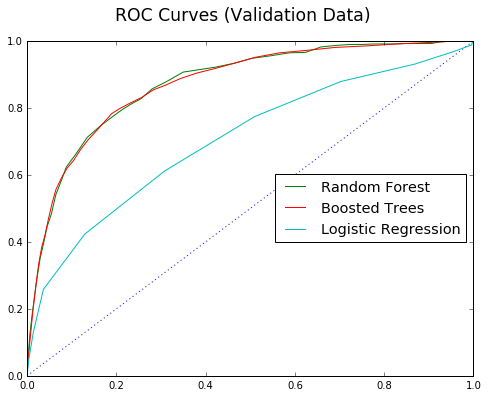

In [20]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.titlesize': 'xx-large',
    'legend.fontsize': 'x-large'})

fig, ax = pyplot.subplots()

ax.plot(
    [0, 1], [0, 1],
    linestyle='dotted')

ax.plot(
    1 - rf_oos_performance.specificity,
    rf_oos_performance.recall,
    label='Random Forest')

ax.plot(
    1 - boost_oos_performance.specificity,
    boost_oos_performance.recall,
    label='Boosted Trees')

ax.plot(
    1 - log_reg_oos_performance.specificity,
    log_reg_oos_performance.recall,
    label='Logistic Regression')

ax.legend(loc='right')
fig.suptitle('ROC Curves (Validation Data)')

We see that Random Forest and Boosted Trees are comparable in OOS performance, and both much better than Logistic Regression. Let's choose the Boosted Trees model for evaluation on the Test set.

We now need to pick a decision threshold for the Boosted Trees model. If we are to be really rigorous, we'll need to pose this trade-off in the context of a financial firm extending loans, e.g. balancing the costs of bad debt and the costs of auditing loans that are healthy. Here, to make life simple, we'll pick a subjective threshold that enables us to anticipate **75%** of the delinquency cases:

In [21]:
recall_threshold = .75
idx = next(i for i in range(100) if boost_oos_performance.recall[i] <= recall_threshold) - 1
selected_prob_threshold = prob_thresholds[idx]
selected_prob_threshold

0.070547966098677431

The OOS performance of the Boosted Trees algorithm at this threshold is as follows:

In [22]:
boost_oos_performance.iloc[idx, :]

threshold      0.070548
accuracy       0.823200
recall         0.756637
specificity    0.828041
precision      0.242439
f1_score       0.367215
deviance       0.358566
Name: 80, dtype: float64

Note that there is trade-off: the precision of the model at this sensitivity threshold is rather low, meaning that there'll be many false positives, i.e. cases with lower financial risk being classified as likely to be delinquent.

# Test Performance of Selected Model

Remember that the Test data may have some missing values. Let's first impute those missing values by the relevant means we've derived from the Training data:

In [23]:
cs_test.ix[:, 'MonthlyIncome'] =\
    cs_test.MonthlyIncome.fillna(cs_train_mean_MonthlyIncome, inplace=False)
cs_test.ix[:, 'NumberOfDependents'] =\
    cs_test.NumberOfDependents.fillna(cs_train_mean_NumberOfDependents, inplace=False)

/usr/local/lib64/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Let's then evaluate the performance of the selected Boosted Trees model at the decision threshold determined above:

In [24]:
boost_test_pred_probs = \
    boost_model.predict_proba(
        X=cs_test[X_var_names])
    
boost_test_oos_performance = \
    bin_classif_eval(
        boost_test_pred_probs[:, 1], cs_test.SeriousDlqin2yrs,
        pos_cat=1, thresholds=selected_prob_threshold)
    
boost_test_oos_performance

{'accuracy': 0.82250000000000001,
 'deviance': 0.36646631580798361,
 'f1_score': 0.35230797299762812,
 'precision': 0.23327829903757097,
 'recall': 0.71935924500186266,
 'specificity': 0.82991951548500631}

We can see that the Test performance is very similar to what we've estimated from the Validation set. The selected model works as expected.

# _BONUS:_ Apache Spark solution

In [25]:
# Apache Spark settings
if AWS_EMR_MODE:
    SPARK_MODE = 'yarn-client'                 # running Spark on AWS EMR YARN cluster
    SPARK_HOME = '/usr/lib/spark'              # default Spark installation folder on AWS EMR master node
    SPARK_DRIVER_MEMORY = '9g'                 # memory allocated to MapReduce driver process
    SPARK_EXECUTOR_MEMORY = '3g'               # memory allocated to each MapReduce executor process
    SPARK_DRIVER_MAX_RESULT_SIZE = '6g'        # maximum size of objects collected back to MapReduce driver process
else:
    SPARK_MODE = 'local'                       # running Spark on single machine
    SPARK_HOME = '/Applications/spark-1.5.2'   # Spark installation folder on my machine
    SPARK_DRIVER_MEMORY = '5g'                 # memory allocated to MapReduce driver process 
    SPARK_EXECUTOR_MEMORY = '1g'               # memory allocated to each MapReduce executor process
    SPARK_DRIVER_MAX_RESULT_SIZE = '3g'        # maximum size of objects collected back to MapReduce driver process

In [26]:
if 'pyspark' not in vars():   # set up Apache Spark environment if not yet done so
    
    # set environment variables for Spark
    os.environ['SPARK_HOME'] = SPARK_HOME
    os.environ['SPARK_HIVE'] = 'true'
    
    # enable importing of PySpark through FindSpark package
    import findspark
    findspark.init()
    
    # import PySpark and set up SparkContext ("sc") & HiveContext ("hc")
    import pyspark
    
    sc = pyspark.SparkContext(
        conf=pyspark.SparkConf()
            .setMaster(SPARK_MODE)
            .setAppName('BostonHousing')
            .set('spark.driver.memory', SPARK_DRIVER_MEMORY)
            .set('spark.executor.memory', SPARK_EXECUTOR_MEMORY)
            .set('spark.driver.maxResultSize', SPARK_DRIVER_MAX_RESULT_SIZE))
    
    hc = pyspark.sql.HiveContext(sc)
    
print('SparkContext:', sc)
print('HiveContext:', hc)

SparkContext: <pyspark.context.SparkContext object at 0x7f704e664710>
HiveContext: <pyspark.sql.context.HiveContext object at 0x7f704e8b4d90>


In [27]:
# imports from PySpark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import \
    RandomForestClassifier as SparkML_RandomForestClassifier, \
    GBTClassifier as SparkML_GBTClassifier, \
    LogisticRegression as SparkML_LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [28]:
# download PySpark_CSV.py and put it into SparkContext
!curl https://raw.githubusercontent.com/seahboonsiew/pyspark-csv/master/pyspark_csv.py --output pyspark_csv.py

sc.addPyFile('pyspark_csv.py')

from pyspark_csv import csvToDataFrame

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5493  100  5493    0     0   4287      0  0:00:01  0:00:01 --:--:--  4288


In [29]:
# download data
os.system('curl %s --output %s' %(DATA_URL, DATA_FILE_NAME))

if AWS_EMR_MODE:
    os.system('hadoop fs -put %s %s' % (DATA_FILE_NAME, DATA_FILE_NAME))

In [30]:
# read data into distributed data frame
credit_scoring_ddf = \
    csvToDataFrame(
        sqlCtx=hc,
        rdd=sc.textFile(DATA_FILE_NAME),
        columns=None,
        sep=',',
        parseDate=True)\
    .cache()

credit_scoring_ddf.registerTempTable('credit_scoring')

credit_scoring_ddf.show(NB_EXAMPLES_TO_SHOW)

+---+----------------+------------------------------------+---+------------------------------------+-----------+-------------+-------------------------------+-----------------------+----------------------------+------------------------------------+------------------+
|   |SeriousDlqin2yrs|RevolvingUtilizationOfUnsecuredLines|age|NumberOfTime30-59DaysPastDueNotWorse|  DebtRatio|MonthlyIncome|NumberOfOpenCreditLinesAndLoans|NumberOfTimes90DaysLate|NumberRealEstateLoansOrLines|NumberOfTime60-89DaysPastDueNotWorse|NumberOfDependents|
+---+----------------+------------------------------------+---+------------------------------------+-----------+-------------+-------------------------------+-----------------------+----------------------------+------------------------------------+------------------+
|  1|               1|                         0.766126609| 45|                                   2|0.802982129|         9120|                             13|                      0|              

In [31]:
# print schema
credit_scoring_ddf.printSchema()

root
 |-- : integer (nullable = true)
 |-- SeriousDlqin2yrs: integer (nullable = true)
 |-- RevolvingUtilizationOfUnsecuredLines: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- NumberOfTime30-59DaysPastDueNotWorse: integer (nullable = true)
 |-- DebtRatio: double (nullable = true)
 |-- MonthlyIncome: string (nullable = true)
 |-- NumberOfOpenCreditLinesAndLoans: integer (nullable = true)
 |-- NumberOfTimes90DaysLate: integer (nullable = true)
 |-- NumberRealEstateLoansOrLines: integer (nullable = true)
 |-- NumberOfTime60-89DaysPastDueNotWorse: integer (nullable = true)
 |-- NumberOfDependents: string (nullable = true)



In [32]:
# remove redundant columns, convert labels to strings
# & convert all integer columns to DoubleType
credit_scoring_ddf = hc.sql(
    "SELECT \
        CASE \
            WHEN SeriousDlqin2yrs > 0 THEN 'yes' \
            ELSE 'no' \
            END \
            AS SeriousDlqin2yrs, \
        %s \
    FROM \
        credit_scoring"
    % ', '.join(['CAST(`%s` AS DOUBLE) AS `%s`' % (x_var_name, x_var_name)
                  for x_var_name in X_var_names]))\
    .cache()

credit_scoring_ddf.registerTempTable('credit_scoring')

credit_scoring_ddf.printSchema()

root
 |-- SeriousDlqin2yrs: string (nullable = false)
 |-- RevolvingUtilizationOfUnsecuredLines: double (nullable = true)
 |-- age: double (nullable = true)
 |-- NumberOfTime30-59DaysPastDueNotWorse: double (nullable = true)
 |-- DebtRatio: double (nullable = true)
 |-- MonthlyIncome: double (nullable = true)
 |-- NumberOfOpenCreditLinesAndLoans: double (nullable = true)
 |-- NumberOfTimes90DaysLate: double (nullable = true)
 |-- NumberRealEstateLoansOrLines: double (nullable = true)
 |-- NumberOfTime60-89DaysPastDueNotWorse: double (nullable = true)
 |-- NumberOfDependents: double (nullable = true)



In [33]:
# split into Train & Test sets
credit_scoring_train_ddf, credit_scoring_test_ddf = \
    credit_scoring_ddf.randomSplit(
        weights=[.3, .7],
        seed=RANDOM_SEED)
    
credit_scoring_train_ddf.cache()
credit_scoring_train_ddf.registerTempTable('credit_scoring_train')

credit_scoring_test_ddf.cache()
credit_scoring_test_ddf.registerTempTable('credit_scoring_test')

In [34]:
# count data completeness in Training set
count_ddf = hc.sql(
    "SELECT \
        %s \
    FROM \
        credit_scoring_train"
    % ', '.join(['COUNT(`%s`) AS `%s`' % (v, v)
                 for v in [y_var_name] + X_var_names]))\
    .cache()

In [35]:
count_ddf.select(
    'SeriousDlqin2yrs',
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse')\
    .show()

+----------------+------------------------------------+-----+------------------------------------+
|SeriousDlqin2yrs|RevolvingUtilizationOfUnsecuredLines|  age|NumberOfTime30-59DaysPastDueNotWorse|
+----------------+------------------------------------+-----+------------------------------------+
|           45008|                               45008|45008|                               45008|
+----------------+------------------------------------+-----+------------------------------------+



In [36]:
count_ddf.select(
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate')\
    .show()

+---------+-------------+-------------------------------+-----------------------+
|DebtRatio|MonthlyIncome|NumberOfOpenCreditLinesAndLoans|NumberOfTimes90DaysLate|
+---------+-------------+-------------------------------+-----------------------+
|    45008|        36081|                          45008|                  45008|
+---------+-------------+-------------------------------+-----------------------+



In [37]:
count_ddf.select(
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents')\
    .show()

+----------------------------+------------------------------------+------------------+
|NumberRealEstateLoansOrLines|NumberOfTime60-89DaysPastDueNotWorse|NumberOfDependents|
+----------------------------+------------------------------------+------------------+
|                       45008|                               45008|             43794|
+----------------------------+------------------------------------+------------------+



In [38]:
# calculate average MonthlyIncome to fill null values
train_avg_monthly_income = hc.sql(
    "SELECT \
        AVG(MonthlyIncome) \
    FROM \
        credit_scoring_train")\
    .rdd\
    .map(lambda row: row[0])\
    .take(1)[0]

train_avg_monthly_income

6570.641639644134

In [39]:
# calculate NumberOfDependents to fill null values
train_avg_nb_dependents = hc.sql(
    "SELECT \
        AVG(NumberOfDependents) \
    FROM \
        credit_scoring_train")\
    .rdd\
    .map(lambda row: row[0])\
    .take(1)[0]

train_avg_nb_dependents

0.7631182353747089

In [40]:
# fill Training set

complete_vars = \
    [y_var_name] + \
    ['RevolvingUtilizationOfUnsecuredLines',
     'age',
     'NumberOfTime30-59DaysPastDueNotWorse',
     'DebtRatio',
     'NumberOfOpenCreditLinesAndLoans',
     'NumberOfTimes90DaysLate',
     'NumberRealEstateLoansOrLines',
     'NumberOfTime60-89DaysPastDueNotWorse']
    
credit_scoring_train_ddf = hc.sql(
    "SELECT \
        %s, \
        COALESCE(MonthlyIncome, %f) AS MonthlyIncome, \
        COALESCE(NumberOfDependents, %f) AS NumberOfDependents \
    FROM \
        credit_scoring_train"
    % (', '.join(['`%s`' % v for v in complete_vars]),
       train_avg_monthly_income,
       train_avg_nb_dependents))\
    .cache()

credit_scoring_train_ddf.registerTempTable('credit_scoring_train')

credit_scoring_train_ddf\
    .select(
        'MonthlyIncome',
        'NumberOfDependents')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+------------------+
|MonthlyIncome|NumberOfDependents|
+-------------+------------------+
|       9120.0|               2.0|
|       2600.0|               1.0|
|       3042.0|               0.0|
|       3300.0|               0.0|
|      63588.0|               0.0|
|       2500.0|               0.0|
|      11362.0|               2.0|
|   6570.64164|               0.0|
|       7916.0|               0.0|
+-------------+------------------+
only showing top 9 rows



In [41]:
credit_scoring_test_ddf = hc.sql(
    "SELECT \
        %s, \
        COALESCE(MonthlyIncome, %f) AS MonthlyIncome, \
        COALESCE(NumberOfDependents, %f) AS NumberOfDependents \
    FROM \
        credit_scoring_test"
    % (', '.join(['`%s`' % v for v in complete_vars]),
       train_avg_monthly_income,
       train_avg_nb_dependents))\
    .cache()

credit_scoring_test_ddf.registerTempTable('credit_scoring_test')

credit_scoring_test_ddf\
    .select(
        'MonthlyIncome',
        'NumberOfDependents')\
    .show(NB_EXAMPLES_TO_SHOW)

+-------------+------------------+
|MonthlyIncome|NumberOfDependents|
+-------------+------------------+
|       3500.0|               1.0|
|   6570.64164|               0.0|
|       3500.0|               0.0|
|   6570.64164|          0.763118|
|      23684.0|               2.0|
|       6501.0|               2.0|
|      12454.0|               2.0|
|      13700.0|               2.0|
|          0.0|               0.0|
+-------------+------------------+
only showing top 9 rows



## Construct pipelines

In [42]:
feature_vector_assembler = \
    VectorAssembler(
        inputCols=X_var_names,
        outputCol='features')

In [43]:
feature_standard_scaler = \
    StandardScaler(
        withMean=True,
        withStd=True,
        inputCol='features',
        outputCol='standardized_features')\
    .fit(dataset=
         feature_vector_assembler.transform(
            credit_scoring_train_ddf))

In [44]:
label_string_indexer = \
    StringIndexer(
        inputCol='SeriousDlqin2yrs',
        outputCol='SeriousDlqin2yrs_idx')\
    .fit(dataset=credit_scoring_train_ddf)

In [45]:
# Random Forest Classifier
rf_classifier = \
    SparkML_RandomForestClassifier(
        featuresCol='features',
        labelCol='SeriousDlqin2yrs_idx',
        predictionCol='y_hat',
        probabilityCol='p_hat',
        rawPredictionCol='raw_pred',
        maxDepth=6,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.0,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        impurity='entropy',
        numTrees=600,
        featureSubsetStrategy='auto',
        seed=RANDOM_SEED)

rf_pipeline_estimator = \
    Pipeline(
        stages=[
            feature_vector_assembler,
            # feature_standard_scaler,
            label_string_indexer,
            rf_classifier])

In [46]:
# GBT Classifier
gbt_classifier = \
    SparkML_GBTClassifier(
        featuresCol='features',
        labelCol='SeriousDlqin2yrs_idx',
        predictionCol='y_hat',
        maxDepth=5,
        maxBins=32,
        minInstancesPerNode=1,
        minInfoGain=0.0,
        maxMemoryInMB=256,
        cacheNodeIds=False,
        checkpointInterval=10,
        lossType='logistic',
        maxIter=100,   # small number of trees to avoid Stack Overflow
        stepSize=.1)

gbt_pipeline_estimator = \
    Pipeline(
        stages=[
            feature_vector_assembler,
            # feature_standard_scaler,
            label_string_indexer,
            gbt_classifier])

In [47]:
# Logistic Regression Classifier
lr_classifier = \
    SparkML_LogisticRegression(
        featuresCol='features',
        labelCol='SeriousDlqin2yrs_idx',
        predictionCol='y_hat',
        maxIter=10000,   # many iterations to compensate for inability to standard-scale
        regParam=0.,
        elasticNetParam=0.,
        tol=1e-9,
        fitIntercept=True,
        threshold=.5,
        # thresholds=None,
        probabilityCol='p_hat',
        rawPredictionCol='raw_pred')

lr_pipeline_estimator = \
    Pipeline(
        stages=[
            feature_vector_assembler,
            # feature_standard_scaler,
            label_string_indexer,
            lr_classifier])

## Fit 3 Regression Pipelines

In [48]:
# fit Random Forest Classifier
rf_model = \
    rf_pipeline_estimator.fit(
        dataset=credit_scoring_train_ddf)

In [49]:
# fit GBT Classifier
# gbt_model = \
#     gbt_pipeline_estimator.fit(
#         dataset=credit_scoring_train_ddf)

In [50]:
# fit Logistic Regression
lr_model = \
    lr_pipeline_estimator.fit(
        dataset=credit_scoring_train_ddf)

## Make Predictions

In [51]:
rf_predictions_ddf = \
    rf_model.transform(
        dataset=credit_scoring_test_ddf)\
    .select(
        'SeriousDlqin2yrs',
        'SeriousDlqin2yrs_idx',
        'raw_pred',
        'p_hat',
        'y_hat')\
    .cache()
        
rf_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------------+--------------------+--------------------+--------------------+-----+
|SeriousDlqin2yrs|SeriousDlqin2yrs_idx|            raw_pred|               p_hat|y_hat|
+----------------+--------------------+--------------------+--------------------+-----+
|              no|                 0.0|[591.547576927535...|[0.98591262821255...|  0.0|
|              no|                 0.0|[586.489189306993...|[0.97748198217832...|  0.0|
|              no|                 0.0|[559.259984641726...|[0.93209997440287...|  0.0|
|              no|                 0.0|[589.320374861145...|[0.98220062476857...|  0.0|
|              no|                 0.0|[585.036821772535...|[0.97506136962089...|  0.0|
|              no|                 0.0|[589.826393843757...|[0.98304398973959...|  0.0|
|              no|                 0.0|[590.305638581826...|[0.98384273096971...|  0.0|
|             yes|                 1.0|[225.200336855522...|[0.37533389475920...|  1.0|
|              no|              

In [52]:
# gbt_predictions_ddf = \
#     gbt_model.transform(
#         dataset=credit_scoring_test_ddf)\
#     .select(
#         'SeriousDlqin2yrs',
#         'SeriousDlqin2yrs_idx',
#         'y_hat')\
#     .cache()
    
# gbt_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

In [53]:
lr_predictions_ddf = \
    lr_model.transform(
        dataset=credit_scoring_test_ddf)\
    .select(
        'SeriousDlqin2yrs',
        'SeriousDlqin2yrs_idx',
        'raw_pred',
        'p_hat',
        'y_hat')\
    .cache()
        
lr_predictions_ddf.show(NB_EXAMPLES_TO_SHOW)

+----------------+--------------------+--------------------+--------------------+-----+
|SeriousDlqin2yrs|SeriousDlqin2yrs_idx|            raw_pred|               p_hat|y_hat|
+----------------+--------------------+--------------------+--------------------+-----+
|              no|                 0.0|[3.41473457755721...|[0.96816186726530...|  0.0|
|              no|                 0.0|[3.30108019522362...|[0.96446584919000...|  0.0|
|              no|                 0.0|[2.65010946046454...|[0.93401773672491...|  0.0|
|              no|                 0.0|[2.25806351810849...|[0.90534381174433...|  0.0|
|              no|                 0.0|[3.27138074101503...|[0.96343384508655...|  0.0|
|              no|                 0.0|[2.73734351921199...|[0.93919456690850...|  0.0|
|              no|                 0.0|[2.81818444837071...|[0.94365060375141...|  0.0|
|             yes|                 1.0|[0.71692055593614...|[0.67192854239434...|  0.0|
|              no|              

## ROC Curves on Test Set

In [54]:
rf_oos_performance = \
    bin_classif_eval(
        numpy.array(rf_predictions_ddf.select('p_hat').rdd.map(lambda row: row[0][1]).collect()),
        numpy.array(rf_predictions_ddf.select('SeriousDlqin2yrs_idx').rdd.map(lambda row: row[0]).collect()),
        pos_cat=1, thresholds=prob_thresholds)

In [55]:
lr_oos_performance = \
    bin_classif_eval(
        numpy.array(lr_predictions_ddf.select('p_hat').rdd.map(lambda row: row[0][1]).collect()),
        numpy.array(lr_predictions_ddf.select('SeriousDlqin2yrs_idx').rdd.map(lambda row: row[0]).collect()),
        pos_cat=1, thresholds=prob_thresholds)

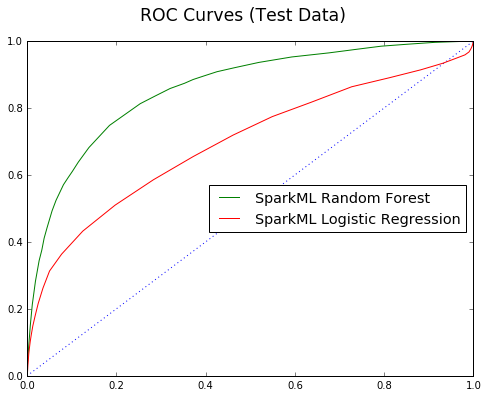

In [56]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),
    'figure.titlesize': 'xx-large',
    'legend.fontsize': 'x-large'})

fig, ax = pyplot.subplots()

ax.plot(
    [0, 1], [0, 1],
    linestyle='dotted')

ax.plot(
    1 - rf_oos_performance.specificity,
    rf_oos_performance.recall,
    label='SparkML Random Forest')

ax.plot(
    1 - lr_oos_performance.specificity,
    lr_oos_performance.recall,
    label='SparkML Logistic Regression')

ax.legend(loc='right')
fig.suptitle('ROC Curves (Test Data)')